In [1]:
from utils import *
from plot_graphe import *

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

In [3]:
def train_loop(epoch, model, train_loader, criterion, optimizer):
  train_acc = 0.
  train_loss = 0.

  # WRITE CODE HERE
  model.train()

  for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        train_acc += acc / len(train_loader)
        train_loss += loss / len(train_loader)
        
  print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
  return train_acc, train_loss

def valid_loop(epoch, model, val_loader, criterion):

  val_acc = 0.
  val_loss = 0.
  
  # WRITE CODE HERE
  model.eval()
  with torch.no_grad():
        for data, label in tqdm(val_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            val_acc += acc / len(val_loader)
            val_loss += val_loss / len(val_loader)



  print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
  return val_acc, val_loss

In [4]:
data = pd.read_csv('X_train_oneHot.csv')

In [5]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = torch.nn.Linear(37, 16)
        self.dropout1 = torch.nn.Dropout(0.8) 
        self.hidden2 = torch.nn.Linear(16, 8)
        self.output = torch.nn.Linear(8, 2) 
    def forward(self, input):
        out = F.relu(self.hidden1(input))
        out = self.dropout1(out)  
        out = F.relu(self.hidden2(out))  
        out = self.output(out)  
        return out


In [6]:
class MLP_PCA(torch.nn.Module):
    def __init__(self):
        super(MLP_PCA, self).__init__()
        self.hidden1 = torch.nn.Linear(30, 16)
        self.dropout1 = torch.nn.Dropout(0.8) 
        self.hidden2 = torch.nn.Linear(16, 8) 
        self.output = torch.nn.Linear(8, 2) 
    def forward(self, input):
        out = F.relu(self.hidden1(input))
        out = self.dropout1(out)  
        out = F.relu(self.hidden2(out))  
        out = self.output(out)  
        return out


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
mlp = MLP()
mlp = mlp.to(device)

In [9]:
def train_network(model,data):
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    for train, val in kf.split(data):
        data_train = data.iloc[train]
        y_train = data_train['isGoal']

        X_train = data_train.drop('isGoal',axis = 1)
        max = np.sort(X_train['speed'].unique())[-3]
        X_train['speed'] = X_train['speed'].replace(np.inf, max )  
        fill_nan_with_mode(X_train)
        X_train =  X_train.astype(float)

        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X_train,y_train)

        scaler = StandardScaler()
        scaler.fit(X_resampled)
        X_resampled =  scaler.transform(X_resampled)


        data_val = data.iloc[val]
        y_val = data_val['isGoal']

        X_val = data_val.drop('isGoal',axis = 1)
        max = np.sort(X_val['speed'].unique())[-3]
        X_val['speed'] = X_val['speed'].replace(np.inf, max )
        fill_nan_with_mode(X_val)
        X_val = X_val.astype(float)
        scaler2 = StandardScaler()
        scaler2.fit(X_val)
        X_val = scaler2.transform(X_val)


        X_train_tensor = torch.tensor(X_resampled).float()
        y_train_tensor = torch.tensor(y_resampled.values).long()
        X_val_tensor = torch.tensor(X_val).float()
        y_val_tensor = torch.tensor(y_val.values).float().long()


        train_dataset = TensorDataset(X_train_tensor, y_train_tensor.squeeze() )
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor.squeeze() )


        batch_size = 16192
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        train_accs, train_losses, val_accs, val_losses = [], [], [], []
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        for epoch in range(5):
            # Training
            train_acc, train_loss = train_loop(epoch, model, train_loader, criterion, optimizer)
            train_accs.append(train_acc)
            train_losses.append(train_loss)

            # Validation
            val_acc, val_loss = valid_loop(epoch,model, val_loader, criterion)
            val_accs.append(val_acc)
            val_losses.append(val_loss)



In [10]:
train_network(mlp,data)

D:\anaconda3\envs\pytorch-gpu\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\anaconda3\envs\pytorch-gpu\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.03it/s]


Epoch: 0 | Train Acc: 0.509088 | Train Loss: 0.697740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


Epoch: 0 | Val Acc: 0.890092   | Val Loss: 0.776707


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.72it/s]


Epoch: 1 | Train Acc: 0.530120 | Train Loss: 0.690942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


Epoch: 1 | Val Acc: 0.887014   | Val Loss: 0.776886


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch: 2 | Train Acc: 0.541711 | Train Loss: 0.688554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.48it/s]


Epoch: 2 | Val Acc: 0.862257   | Val Loss: 0.784389


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch: 3 | Train Acc: 0.549787 | Train Loss: 0.687009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch: 3 | Val Acc: 0.842687   | Val Loss: 0.781949


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch: 4 | Train Acc: 0.555926 | Train Loss: 0.684760


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


Epoch: 4 | Val Acc: 0.814601   | Val Loss: 0.780497


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch: 0 | Train Acc: 0.559085 | Train Loss: 0.683021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


Epoch: 0 | Val Acc: 0.806677   | Val Loss: 0.776251


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch: 1 | Train Acc: 0.564216 | Train Loss: 0.681011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


Epoch: 1 | Val Acc: 0.788616   | Val Loss: 0.772042


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch: 2 | Train Acc: 0.569881 | Train Loss: 0.679150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


Epoch: 2 | Val Acc: 0.770906   | Val Loss: 0.767544


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch: 3 | Train Acc: 0.575503 | Train Loss: 0.676135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


Epoch: 3 | Val Acc: 0.751991   | Val Loss: 0.763922


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch: 4 | Train Acc: 0.581338 | Train Loss: 0.673472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


Epoch: 4 | Val Acc: 0.734832   | Val Loss: 0.760399


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.57it/s]


Epoch: 0 | Train Acc: 0.585684 | Train Loss: 0.671125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


Epoch: 0 | Val Acc: 0.722737   | Val Loss: 0.754300


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch: 1 | Train Acc: 0.590467 | Train Loss: 0.668286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


Epoch: 1 | Val Acc: 0.708483   | Val Loss: 0.750695


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch: 2 | Train Acc: 0.597387 | Train Loss: 0.665170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


Epoch: 2 | Val Acc: 0.695652   | Val Loss: 0.747859


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.64it/s]


Epoch: 3 | Train Acc: 0.600814 | Train Loss: 0.662529


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch: 3 | Val Acc: 0.685907   | Val Loss: 0.744392


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.52it/s]


Epoch: 4 | Train Acc: 0.605744 | Train Loss: 0.659162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.34it/s]


Epoch: 4 | Val Acc: 0.674407   | Val Loss: 0.742101


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch: 0 | Train Acc: 0.611249 | Train Loss: 0.656245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


Epoch: 0 | Val Acc: 0.666466   | Val Loss: 0.739722


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch: 1 | Train Acc: 0.613075 | Train Loss: 0.653955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch: 1 | Val Acc: 0.655347   | Val Loss: 0.736891


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.47it/s]


Epoch: 2 | Train Acc: 0.617341 | Train Loss: 0.650972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


Epoch: 2 | Val Acc: 0.647159   | Val Loss: 0.733281


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.51it/s]


Epoch: 3 | Train Acc: 0.620549 | Train Loss: 0.648770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


Epoch: 3 | Val Acc: 0.641070   | Val Loss: 0.728025


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.49it/s]


Epoch: 4 | Train Acc: 0.625093 | Train Loss: 0.645283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


Epoch: 4 | Val Acc: 0.632014   | Val Loss: 0.723893


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.49it/s]


Epoch: 0 | Train Acc: 0.627717 | Train Loss: 0.643081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


Epoch: 0 | Val Acc: 0.615524   | Val Loss: 0.762736


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.38it/s]


Epoch: 1 | Train Acc: 0.629804 | Train Loss: 0.640832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


Epoch: 1 | Val Acc: 0.611732   | Val Loss: 0.758410


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.50it/s]


Epoch: 2 | Train Acc: 0.632290 | Train Loss: 0.639049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


Epoch: 2 | Val Acc: 0.603793   | Val Loss: 0.756220


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch: 3 | Train Acc: 0.634720 | Train Loss: 0.636380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


Epoch: 3 | Val Acc: 0.597414   | Val Loss: 0.753676


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.43it/s]


Epoch: 4 | Train Acc: 0.636806 | Train Loss: 0.634433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]

Epoch: 4 | Val Acc: 0.592530   | Val Loss: 0.750985


In [11]:
X,y = get_X_y(data)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=1)

In [13]:
max = np.sort(X_val['speed'].unique())[-3]
X_val['speed'] = X_val['speed'].replace(np.inf, max )
fill_nan_with_mode(X_val)
X_val = X_val.astype(float)

In [14]:
X_val_tensor = torch.tensor(X_val.values).float()
y_val_tensor = torch.tensor(y_val.values).long()

In [15]:
with torch.no_grad():
    X_val_tensor = X_val_tensor.to(device)
    
    output = mlp(X_val_tensor)


    probabilities = torch.softmax(output, dim=1)


    predictions = torch.argmax(probabilities, dim=1)

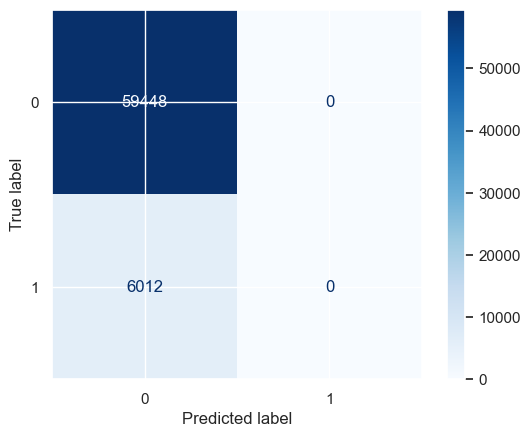

In [16]:
y_val_tensor_cpu = y_val_tensor.cpu()
predictions_cpu = predictions.cpu()
prob_cpu = probabilities.cpu()

y_val_numpy = y_val_tensor_cpu.numpy()
predictions_numpy = predictions_cpu.numpy()

plot_cmap(y_val_numpy, predictions_numpy)

In [17]:
def plot_roc_curve_mlp(prob_cpu, y_val_numpy, title):
    fpr, tpr, thresholds = roc_curve(y_val_numpy, prob_cpu[:, 1])

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, label='random baseline', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


In [18]:
def plot_goal_ratio_mlp(prob_cpu, y_val_numpy,predictions_cpu , title):
    '''
    plot the graph of goal ratio
    input: model - the binary classification model
           X_val - the validation data
           y_val - the real labels of validation data
    '''
    bins = list(np.arange(0, 105, 5))
    bin_centers = list(np.arange(2.5, 100, 5.0))

    df_prob = pd.DataFrame({
        'goal_pred': predictions_cpu,
        'goal': y_val.reset_index(drop=True),
        'goal_prob': prob_cpu[:, 1] * 100
    })

    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()

    df_prob['percentile'] = df_prob['goal_prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels=bin_centers)

    df_prob_binned = df_prob[['goal_perc_bins', 'shot', 'goal']].groupby(['goal_perc_bins'],
                                                                         observed=False).sum().reset_index()

    df_prob_binned['goal_rate'] = (df_prob_binned['goal'] / df_prob_binned['shot'])
    df_prob_binned['goal_cum'] = (df_prob_binned['goal'] / sum_goal)
    df_prob_binned['goal_cumsum'] = 1 - df_prob_binned['goal_cum'].cumsum()

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title(title)
    sns.lineplot(x='goal_perc_bins', y='goal_rate', data=df_prob_binned, legend=False, linewidth=2.5)
    plt.xlabel('Shot Probability Model Percentile')
    plt.ylabel('Goals / (Shots + Goals)')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.xticks(np.arange(0, 120, 20))
    plt.show()


In [19]:
def plot_cumu_goal_mlp(prob_cpu, y_val_numpy,predictions_cpu , title):
    bins = list(np.arange(0, 105, 5))
    bin_centers = list(np.arange(2.5, 100, 5.0))



    df_prob = pd.DataFrame({
        'goal_pred': predictions_cpu,
        'goal': y_val.reset_index(drop=True),
        'goal_prob': prob_cpu[:, 1] * 100
    })

    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()

    df_prob['percentile'] = df_prob['goal_prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels=bin_centers)

    df_prob_binned = df_prob[['goal_perc_bins', 'shot', 'goal']].groupby(['goal_perc_bins'],
                                                                         observed=False).sum().reset_index()

    df_prob_binned['goal_rate'] = (df_prob_binned['goal'] / df_prob_binned['shot'])
    df_prob_binned['goal_cum'] = (df_prob_binned['goal'] / sum_goal)
    df_prob_binned['goal_cumsum'] = 1 - df_prob_binned['goal_cum'].cumsum()
    fig = plt.figure(figsize=(10, 5))
    plt.title(title)
    ax = sns.lineplot(x='goal_perc_bins', y='goal_cumsum', data=df_prob_binned, legend=False, linewidth=2.5)
    plt.xlabel('shot probability model percentile')
    plt.ylabel('proportion')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.xticks(np.arange(0, 120, 20))
    fig.show()


In [20]:
def plot_calib_mlp(prob_cpu, y_val_numpy,predictions_cpu , title):

    df_prob = pd.DataFrame({
        'goal_pred': predictions_cpu,
        'goal': y_val.reset_index(drop=True),
        'goal_prob': prob_cpu[:, 1] * 100
    })
    df_prob['shot'] = 1

    fig = plt.figure(figsize=(10, 6))
    plt.title(title)
    prob_true_da, prob_pred_da = calibration_curve(df_prob['goal'], df_prob['goal_prob'] / 100, n_bins=20)
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(prob_pred_da, prob_true_da, "s-", label='Using Distance and angle')
    plt.xlabel('shot probability model percentile')
    plt.ylabel('proportion')
    plt.legend(loc="upper left")
    plt.xticks(np.arange(0, 1.2, 0.2))
    plt.yticks(np.arange(0, 1.2, 0.2))
    fig.show()
    

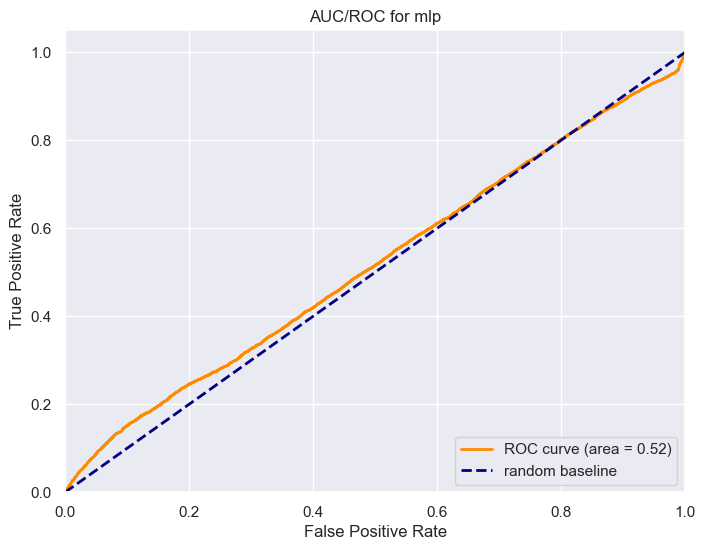

In [21]:
plot_roc_curve_mlp(prob_cpu, y_val_numpy, title = 'AUC/ROC for mlp')

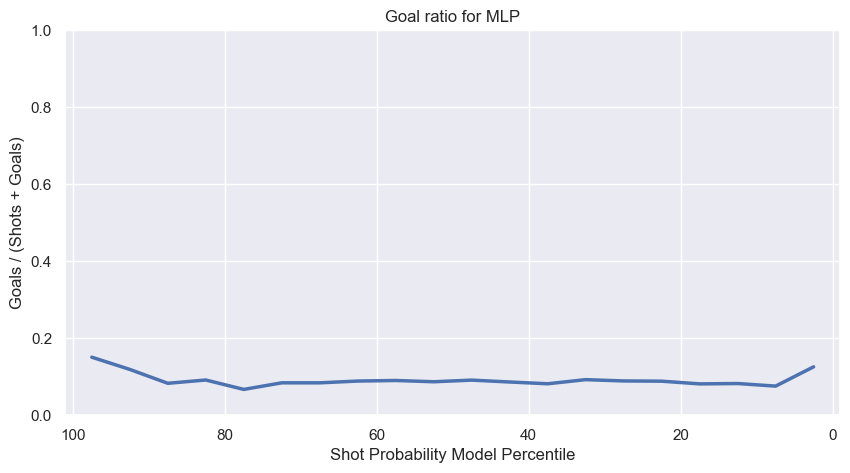

In [22]:
plot_goal_ratio_mlp(prob_cpu, y_val_numpy,predictions_cpu, title = 'Goal ratio for MLP')

C:\Users\1\AppData\Local\Temp\ipykernel_9272\1863790723.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


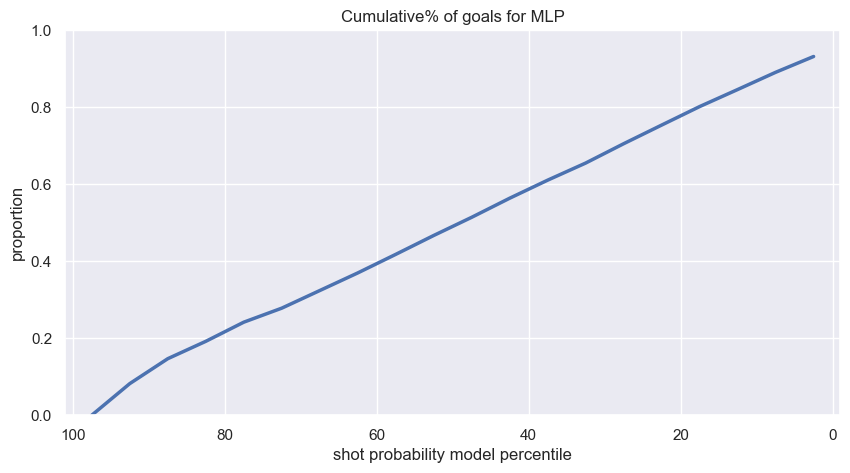

In [23]:
plot_cumu_goal_mlp(prob_cpu, y_val_numpy,predictions_cpu, title = 'Cumulative% of goals for MLP')

C:\Users\1\AppData\Local\Temp\ipykernel_9272\1252129143.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


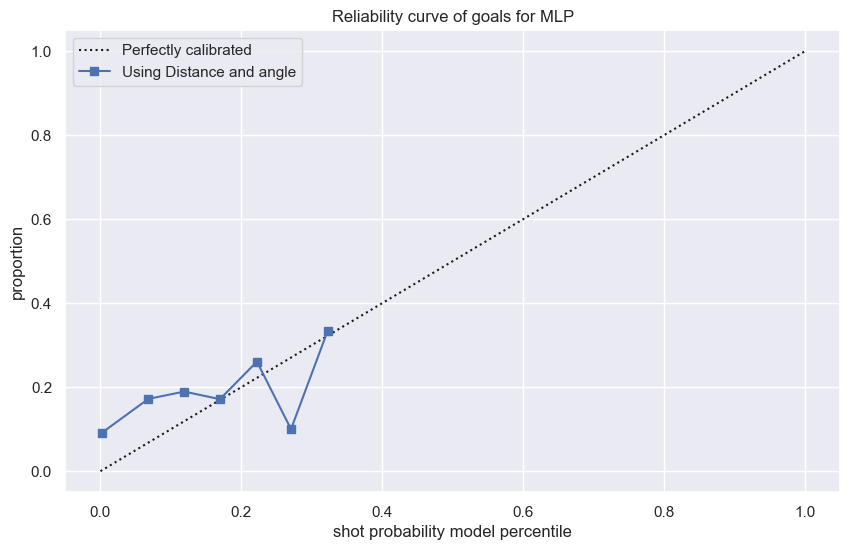

In [24]:
plot_calib_mlp(prob_cpu, y_val_numpy,predictions_cpu, title = 'Reliability curve of goals for MLP')

## With PCA

In [25]:
mlp_pca = MLP_PCA()
mlp_pca.to(device)

MLP_PCA(
  (hidden1): Linear(in_features=30, out_features=16, bias=True)
  (dropout1): Dropout(p=0.8, inplace=False)
  (hidden2): Linear(in_features=16, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=2, bias=True)
)

In [26]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)
for train, val in kf.split(data):
    data_train = data.iloc[train]
    y_train = data_train['isGoal']

    X_train = data_train.drop('isGoal',axis = 1)
    max = np.sort(X_train['speed'].unique())[-3]
    X_train['speed'] = X_train['speed'].replace(np.inf, max )  
    fill_nan_with_mode(X_train)
  

    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_train,y_train)

    pca = get_95_PCA(X_resampled)
    X_resampled = pca.transform(X_resampled)

    scaler = StandardScaler()
    scaler.fit(X_resampled)
    X_resampled =  scaler.transform(X_resampled)


    data_val = data.iloc[val]
    y_val = data_val['isGoal']

    X_val = data_val.drop('isGoal',axis = 1)
    max = np.sort(X_val['speed'].unique())[-3]
    X_val['speed'] = X_val['speed'].replace(np.inf, max )
    fill_nan_with_mode(X_val)
    X_val = X_val.astype(float)
    scaler2 = StandardScaler()
    scaler2.fit(X_val)
    X_val = scaler2.transform(X_val)
    X_val = pca.transform(X_val)
    
    X_train_tensor = torch.tensor(X_resampled).float()
    y_train_tensor = torch.tensor(y_resampled.values).long()
    X_val_tensor = torch.tensor(X_val).float()
    y_val_tensor = torch.tensor(y_val.values).float().long()


    train_dataset = TensorDataset(X_train_tensor, y_train_tensor.squeeze() )
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor.squeeze() )


    batch_size = 1024
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_accs, train_losses, val_accs, val_losses = [], [], [], []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(mlp_pca.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(5):
        # Training
        train_acc, train_loss = train_loop(epoch, mlp_pca, train_loader, criterion, optimizer)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Validation
        val_acc, val_loss = valid_loop(epoch,mlp_pca, val_loader, criterion)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
    




D:\anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 123.55it/s]


Epoch: 0 | Train Acc: 0.534699 | Train Loss: 0.688975


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 151.51it/s]


Epoch: 0 | Val Acc: 0.535284   | Val Loss: 0.697202


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 122.54it/s]


Epoch: 1 | Train Acc: 0.572135 | Train Loss: 0.676538


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 136.96it/s]


Epoch: 1 | Val Acc: 0.438529   | Val Loss: 0.730807


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 124.07it/s]


Epoch: 2 | Train Acc: 0.610411 | Train Loss: 0.661013


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 126.94it/s]


Epoch: 2 | Val Acc: 0.438220   | Val Loss: 0.810121


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 124.64it/s]


Epoch: 3 | Train Acc: 0.630647 | Train Loss: 0.652157


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.50it/s]


Epoch: 3 | Val Acc: 0.468808   | Val Loss: 0.832728


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 124.84it/s]


Epoch: 4 | Train Acc: 0.638505 | Train Loss: 0.647377


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 135.80it/s]


Epoch: 4 | Val Acc: 0.485534   | Val Loss: 0.847328


D:\anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 124.47it/s]


Epoch: 0 | Train Acc: 0.630719 | Train Loss: 0.653623


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 127.19it/s]


Epoch: 0 | Val Acc: 0.537654   | Val Loss: 0.778946


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 125.48it/s]


Epoch: 1 | Train Acc: 0.646180 | Train Loss: 0.642498


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 150.98it/s]


Epoch: 1 | Val Acc: 0.544670   | Val Loss: 0.738997


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 126.19it/s]


Epoch: 2 | Train Acc: 0.650113 | Train Loss: 0.638813


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 126.19it/s]


Epoch: 2 | Val Acc: 0.560767   | Val Loss: 0.686468


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 123.96it/s]


Epoch: 3 | Train Acc: 0.653417 | Train Loss: 0.636127


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 131.22it/s]


Epoch: 3 | Val Acc: 0.562855   | Val Loss: 0.669968


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 124.29it/s]


Epoch: 4 | Train Acc: 0.654989 | Train Loss: 0.634168


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 144.52it/s]


Epoch: 4 | Val Acc: 0.561078   | Val Loss: 0.660866


D:\anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 122.39it/s]


Epoch: 0 | Train Acc: 0.543055 | Train Loss: 0.694314


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 136.53it/s]


Epoch: 0 | Val Acc: 0.717875   | Val Loss: 0.634907


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 121.04it/s]


Epoch: 1 | Train Acc: 0.578072 | Train Loss: 0.668784


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 130.82it/s]


Epoch: 1 | Val Acc: 0.590690   | Val Loss: 0.686233


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 122.44it/s]


Epoch: 2 | Train Acc: 0.613620 | Train Loss: 0.655423


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 146.00it/s]


Epoch: 2 | Val Acc: 0.537925   | Val Loss: 0.746188


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 125.21it/s]


Epoch: 3 | Train Acc: 0.628003 | Train Loss: 0.649052


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 130.82it/s]


Epoch: 3 | Val Acc: 0.517575   | Val Loss: 0.743406


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 126.66it/s]


Epoch: 4 | Train Acc: 0.640451 | Train Loss: 0.642549


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 134.10it/s]


Epoch: 4 | Val Acc: 0.521227   | Val Loss: 0.713733


D:\anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 126.88it/s]


Epoch: 0 | Train Acc: 0.610265 | Train Loss: 0.660604


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 151.70it/s]


Epoch: 0 | Val Acc: 0.537181   | Val Loss: 0.777916


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 124.47it/s]


Epoch: 1 | Train Acc: 0.651089 | Train Loss: 0.637544


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 134.95it/s]


Epoch: 1 | Val Acc: 0.530704   | Val Loss: 0.696056


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 121.75it/s]


Epoch: 2 | Train Acc: 0.655811 | Train Loss: 0.633371


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 138.74it/s]


Epoch: 2 | Val Acc: 0.519215   | Val Loss: 0.690346


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 125.65it/s]


Epoch: 3 | Train Acc: 0.658341 | Train Loss: 0.631443


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 152.78it/s]


Epoch: 3 | Val Acc: 0.509816   | Val Loss: 0.652888


100%|███████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 122.62it/s]


Epoch: 4 | Train Acc: 0.660123 | Train Loss: 0.630268


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 127.44it/s]


Epoch: 4 | Val Acc: 0.513699   | Val Loss: 0.635952


D:\anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 463/463 [00:03<00:00, 119.84it/s]


Epoch: 0 | Train Acc: 0.652215 | Train Loss: 0.640841


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 128.72it/s]


Epoch: 0 | Val Acc: 0.473751   | Val Loss: 0.694500


100%|███████████████████████████████████████████████████████████████████████████████| 463/463 [00:03<00:00, 120.86it/s]


Epoch: 1 | Train Acc: 0.659133 | Train Loss: 0.633730


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 155.75it/s]


Epoch: 1 | Val Acc: 0.470485   | Val Loss: 0.667929


100%|███████████████████████████████████████████████████████████████████████████████| 463/463 [00:03<00:00, 123.62it/s]


Epoch: 2 | Train Acc: 0.659990 | Train Loss: 0.632588


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 128.46it/s]


Epoch: 2 | Val Acc: 0.472078   | Val Loss: 0.663157


100%|███████████████████████████████████████████████████████████████████████████████| 463/463 [00:03<00:00, 123.71it/s]


Epoch: 3 | Train Acc: 0.660325 | Train Loss: 0.632101


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 135.52it/s]


Epoch: 3 | Val Acc: 0.477532   | Val Loss: 0.659685


100%|███████████████████████████████████████████████████████████████████████████████| 463/463 [00:03<00:00, 124.37it/s]


Epoch: 4 | Train Acc: 0.660392 | Train Loss: 0.632005


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 148.19it/s]

Epoch: 4 | Val Acc: 0.485688   | Val Loss: 0.649515


In [27]:
data = pd.read_csv('X_train_oneHot.csv')

In [28]:
X,y = get_X_y(data)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=1)
fill_nan_with_mode(X_train)
X_train['speed'] = replace_inf(X_train)

X_val['speed'] =replace_inf(X_val)
fill_nan_with_mode(X_val)

In [29]:
X_train.shape

(261838, 37)

In [30]:
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)

In [31]:
X_train_pca.shape

(261838, 30)

In [32]:
X_val_pca = pca.transform(X_val)

In [33]:
X_val_tensor_2 = torch.tensor(X_val_pca).float()
y_val_tensor_2 = torch.tensor(y_val.values).long()

In [34]:
X_train_pca.shape 

(261838, 30)

In [35]:
with torch.no_grad():
    X_val_tensor_2 = X_val_tensor_2.to(device)
    
    output_2 = mlp_pca(X_val_tensor_2)


    probabilities_2 = torch.softmax(output_2, dim=1)


    predictions_2 = torch.argmax(probabilities_2, dim=1)

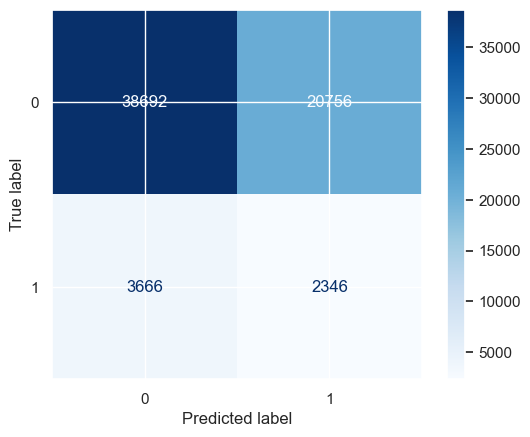

In [36]:
y_val_tensor_cpu_2 = y_val_tensor_2.cpu()
predictions_cpu_2 = predictions_2.cpu()
prob_cpu_2 = probabilities_2.cpu()

y_val_numpy_2 = y_val_tensor_cpu_2.numpy()
predictions_numpy_2 = predictions_cpu_2.numpy()

plot_cmap(y_val_numpy_2, predictions_numpy_2)

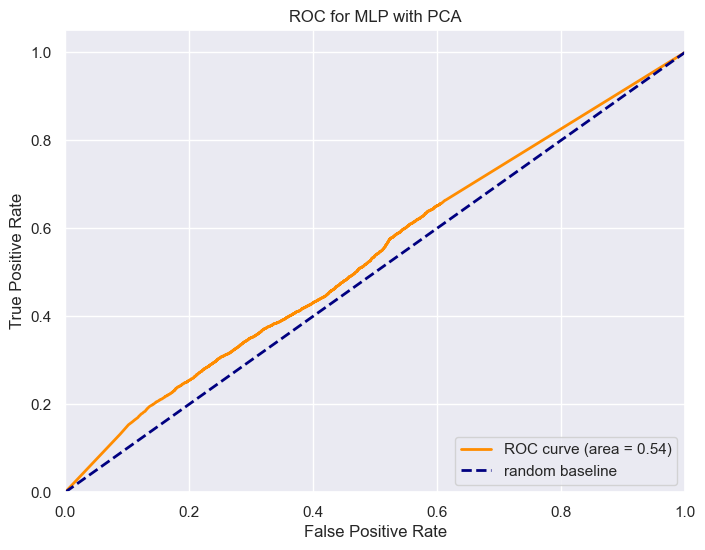

In [37]:
plot_roc_curve_mlp(prob_cpu_2, y_val_numpy_2, title = 'ROC for MLP with PCA')

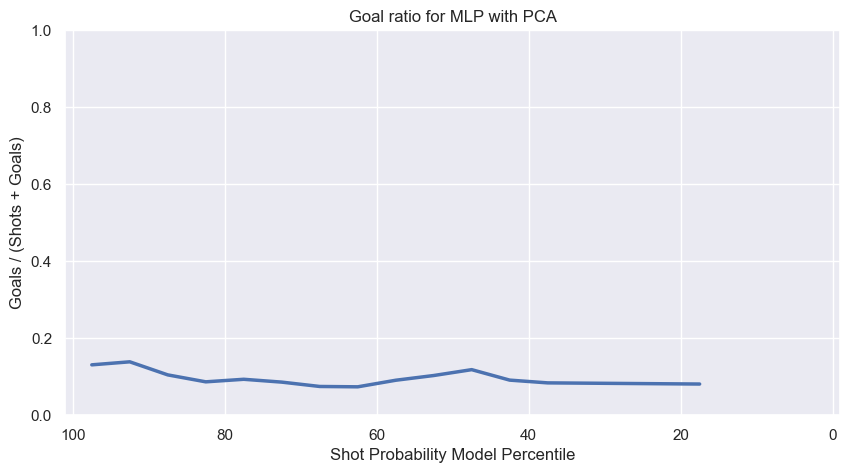

In [38]:
plot_goal_ratio_mlp(prob_cpu_2, y_val_numpy_2,predictions_cpu_2, title = 'Goal ratio for MLP with PCA')

C:\Users\1\AppData\Local\Temp\ipykernel_9272\1863790723.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


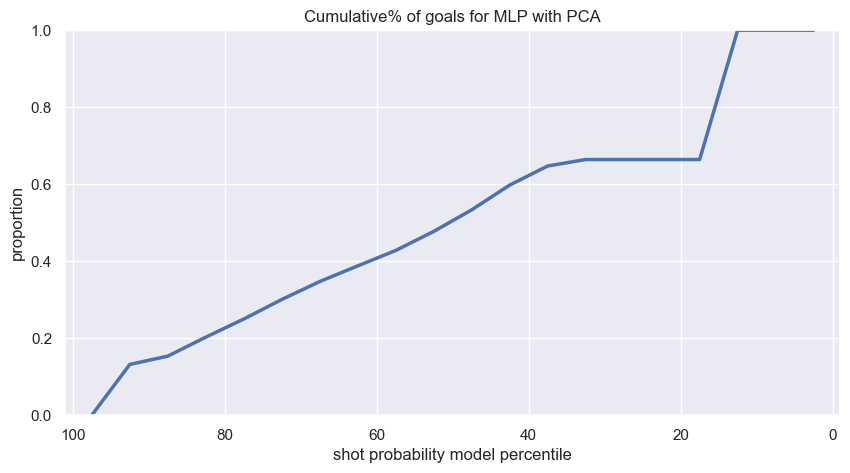

In [39]:
plot_cumu_goal_mlp(prob_cpu_2, y_val_numpy_2,predictions_cpu_2, title = 'Cumulative% of goals for MLP with PCA')

C:\Users\1\AppData\Local\Temp\ipykernel_9272\1252129143.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


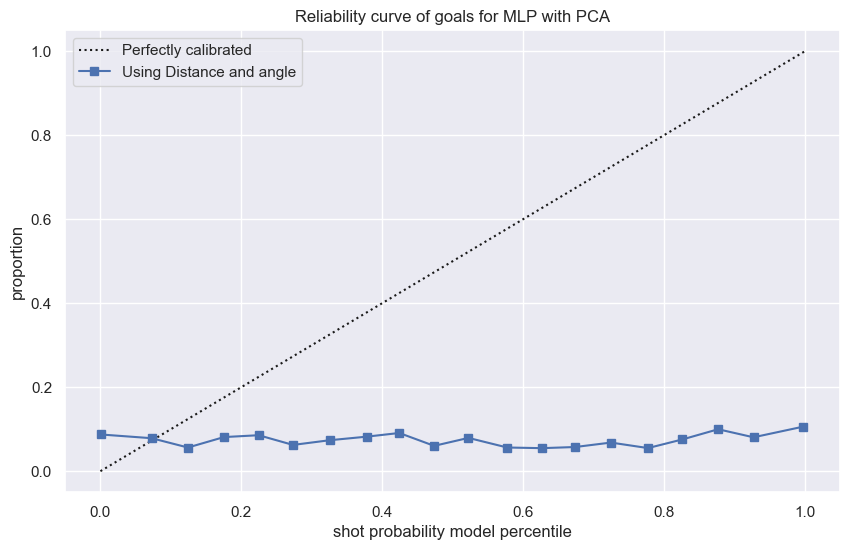

In [40]:
plot_calib_mlp(prob_cpu_2, y_val_numpy_2,predictions_cpu_2, title = 'Reliability curve of goals for MLP with PCA')